# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

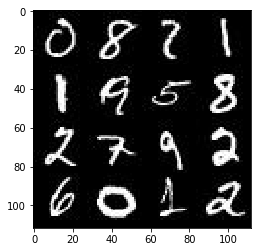

In [2]:
show_n_images = 20

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

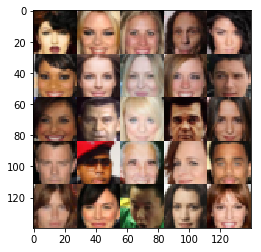

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    learning_rate = tf.placeholder(tf.float32, name='lr')
    tensor_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='tensor_real')
    tensor_z = tf.placeholder(tf.float32, (None, z_dim), name='tensor_z')
    return tensor_real, tensor_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
         # Input layer is 28x28x3
        #print(images.shape)
        x1 = tf.layers.conv2d(images, 32, 3, strides=1, padding='same')#27*27*32
        x1 =  tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(x1, 64, 5, strides=2, padding='same')#14*14*64
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 =  tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d(x2, 128, 5, strides=1, padding='valid')#9*9*128
        x3 = tf.layers.batch_normalization(x3, training=True)
        tf.maximum(alpha * x3, x3)
        
        x4 = tf.layers.conv2d(x3, 256, 3, strides=2, padding='same')#5*5*256
        x4 = tf.layers.batch_normalization(x4, training=True)
        x4 =  tf.maximum(alpha * x4, x4)
        
        x5 = tf.layers.conv2d(x4, 512, 3, strides=1, padding='valid')#3*3*512
        x5 = tf.layers.batch_normalization(x4, training=True)
        x5 =  tf.maximum(alpha * x4, x4)
        
        flatten_dim = x5.get_shape()[1]*x3.get_shape()[2]*x3.get_shape()[3]
        #print(int(flatten_dim))
        flatten  = tf.reshape(x3, (-1,int(flatten_dim)))
        #print(flatten.shape)
        logits = tf.layers.dense(flatten,1)
        #print(logits.shape)
        output = tf.sigmoid(logits)
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, reuse = False, alpha=0.2, train = True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=reuse):
        # print(out_channel_dim)
        # First fully connected layer
        x1 = tf.layers.dense(z, 512*1*1)
        x1 = tf.reshape(x1, (-1, 1, 1, 512))
        x1 = tf.layers.batch_normalization(x1, training=train)
        x1 =  tf.maximum(alpha * x1, x1)#1*1*512
        
        # second conv layer
        x2 = tf.layers.conv2d_transpose(x1, 512, 5, strides=7, padding="same")
        x2 = tf.layers.batch_normalization(x2, training=train)
        x2 =  tf.maximum(alpha * x2, x2)#7*7*512
        
        # third conv layer
        x3 = tf.layers.conv2d_transpose(x2, 256, 5, strides=2, padding="same")
        x3 = tf.layers.batch_normalization(x3, training=train)
        x3 =  tf.maximum(alpha * x3, x3)#14*14*256
        
        # forth conv layer
        x4 = tf.layers.conv2d_transpose(x3, 128, 5, strides=1, padding="same")
        x4 = tf.layers.batch_normalization(x4, training=train)
        x4 =  tf.maximum(alpha * x4, x4)#14*14*128
        # print(x3.shape)
        
        # output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding="same") #28*28*out_channel_dim     
        out = tf.tanh(logits)
        #print(out.shape)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

AssertionError: tf.variable_scope called with wrong arguments in Generator Inference(reuse=True)

### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim, smooth=0.1,alpha =0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True,alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim,reuse=True, train = False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, alpha = 0.2):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    tensor_real, tensor_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(tensor_real, tensor_z, data_shape[3], alpha=alpha)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    step = 0
    losses = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(2*batch_size):
                # TODO: Train Model
                step += 1
                #print(type(learning_rate))
                # sample random noise for generator
                batch_z = np.random.uniform(1,-1,size = (batch_size, z_dim))
                
                # run optimizer
                _ = sess.run(d_train_opt, feed_dict={tensor_real: batch_images, tensor_z: batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={tensor_real: batch_images, tensor_z:batch_z, lr:learning_rate})
                
                if step % 10 == 0:
                    train_d_loss = d_loss.eval({tensor_real:batch_images, tensor_z: batch_z})
                    train_g_loss = g_loss.eval({tensor_z:batch_z})
                    print("Step {}, Epoch {}/{}...".format(step, epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_d_loss),
                          "Generator Loss: {:.4f}".format(train_g_loss))
                    losses.append((train_d_loss, train_g_loss))
                    
                if step%100 == 0:
                    show_generator_output(sess, batch_size, tensor_z, data_shape[3], data_image_mode)
                
    
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Step 10, Epoch 1/2... Discriminator Loss: 0.6087... Generator Loss: 5.3364
Step 20, Epoch 1/2... Discriminator Loss: 1.8863... Generator Loss: 0.8584
Step 30, Epoch 1/2... Discriminator Loss: 3.5282... Generator Loss: 0.0535
Step 40, Epoch 1/2... Discriminator Loss: 0.5608... Generator Loss: 4.3242
Step 50, Epoch 1/2... Discriminator Loss: 0.7949... Generator Loss: 1.6061
Step 60, Epoch 1/2... Discriminator Loss: 0.4192... Generator Loss: 3.1484
Step 70, Epoch 1/2... Discriminator Loss: 0.3669... Generator Loss: 4.7283
Step 80, Epoch 1/2... Discriminator Loss: 0.3753... Generator Loss: 3.9521
Step 90, Epoch 1/2... Discriminator Loss: 0.4022... Generator Loss: 5.4996
Step 100, Epoch 1/2... Discriminator Loss: 1.5990... Generator Loss: 0.6314


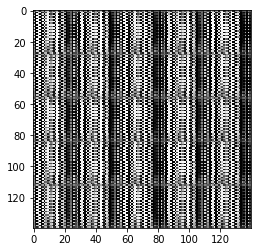

Step 110, Epoch 1/2... Discriminator Loss: 0.3894... Generator Loss: 5.9793
Step 120, Epoch 1/2... Discriminator Loss: 0.3606... Generator Loss: 5.1451
Step 130, Epoch 1/2... Discriminator Loss: 0.4154... Generator Loss: 4.5398
Step 140, Epoch 1/2... Discriminator Loss: 0.5106... Generator Loss: 2.0774
Step 150, Epoch 1/2... Discriminator Loss: 0.4336... Generator Loss: 3.2775
Step 160, Epoch 1/2... Discriminator Loss: 0.3536... Generator Loss: 6.1201
Step 170, Epoch 1/2... Discriminator Loss: 0.3928... Generator Loss: 3.3660
Step 180, Epoch 1/2... Discriminator Loss: 0.5230... Generator Loss: 4.9155
Step 190, Epoch 1/2... Discriminator Loss: 1.5335... Generator Loss: 1.1699
Step 200, Epoch 1/2... Discriminator Loss: 1.2216... Generator Loss: 3.7302


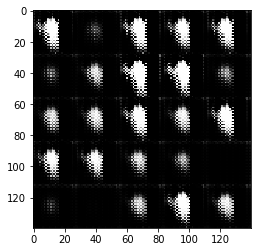

Step 210, Epoch 1/2... Discriminator Loss: 0.5704... Generator Loss: 2.1846
Step 220, Epoch 1/2... Discriminator Loss: 0.4147... Generator Loss: 4.1881
Step 230, Epoch 1/2... Discriminator Loss: 1.5953... Generator Loss: 2.6517
Step 240, Epoch 1/2... Discriminator Loss: 0.9539... Generator Loss: 2.8323
Step 250, Epoch 1/2... Discriminator Loss: 0.6191... Generator Loss: 2.1563
Step 260, Epoch 1/2... Discriminator Loss: 0.5322... Generator Loss: 2.0448
Step 270, Epoch 1/2... Discriminator Loss: 0.4940... Generator Loss: 2.5537
Step 280, Epoch 1/2... Discriminator Loss: 1.2758... Generator Loss: 5.7386
Step 290, Epoch 1/2... Discriminator Loss: 0.4051... Generator Loss: 3.9735
Step 300, Epoch 1/2... Discriminator Loss: 0.3896... Generator Loss: 3.8206


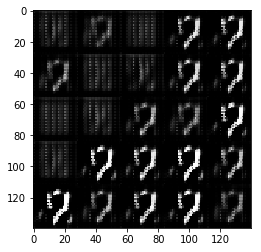

Step 310, Epoch 1/2... Discriminator Loss: 0.3810... Generator Loss: 4.2480
Step 320, Epoch 1/2... Discriminator Loss: 0.3850... Generator Loss: 3.5531
Step 330, Epoch 1/2... Discriminator Loss: 0.4095... Generator Loss: 3.2177
Step 340, Epoch 1/2... Discriminator Loss: 0.3993... Generator Loss: 3.1893
Step 350, Epoch 1/2... Discriminator Loss: 0.4639... Generator Loss: 2.7986
Step 360, Epoch 1/2... Discriminator Loss: 0.4347... Generator Loss: 2.8644
Step 370, Epoch 1/2... Discriminator Loss: 0.3649... Generator Loss: 3.8331
Step 380, Epoch 1/2... Discriminator Loss: 0.3536... Generator Loss: 4.2086
Step 390, Epoch 1/2... Discriminator Loss: 0.3928... Generator Loss: 3.2822
Step 400, Epoch 1/2... Discriminator Loss: 0.3779... Generator Loss: 3.7442


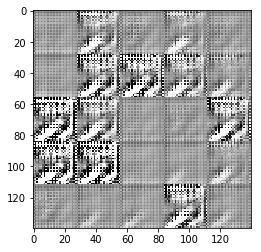

Step 410, Epoch 1/2... Discriminator Loss: 0.3773... Generator Loss: 3.7476
Step 420, Epoch 1/2... Discriminator Loss: 0.3543... Generator Loss: 4.2283
Step 430, Epoch 1/2... Discriminator Loss: 0.3995... Generator Loss: 4.1471
Step 440, Epoch 1/2... Discriminator Loss: 0.3594... Generator Loss: 4.4580
Step 450, Epoch 1/2... Discriminator Loss: 0.3391... Generator Loss: 6.5197
Step 460, Epoch 1/2... Discriminator Loss: 0.4205... Generator Loss: 5.6782
Step 470, Epoch 1/2... Discriminator Loss: 0.4584... Generator Loss: 4.7779
Step 480, Epoch 1/2... Discriminator Loss: 0.3854... Generator Loss: 4.7216
Step 490, Epoch 1/2... Discriminator Loss: 3.6313... Generator Loss: 0.1642
Step 500, Epoch 1/2... Discriminator Loss: 1.9790... Generator Loss: 1.1905


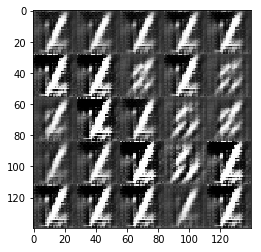

Step 510, Epoch 1/2... Discriminator Loss: 0.6168... Generator Loss: 5.6579
Step 520, Epoch 1/2... Discriminator Loss: 0.5422... Generator Loss: 2.0814
Step 530, Epoch 1/2... Discriminator Loss: 0.3568... Generator Loss: 5.7802
Step 540, Epoch 1/2... Discriminator Loss: 0.3741... Generator Loss: 4.2847
Step 550, Epoch 1/2... Discriminator Loss: 0.3760... Generator Loss: 4.1040
Step 560, Epoch 1/2... Discriminator Loss: 0.3825... Generator Loss: 3.7438
Step 570, Epoch 1/2... Discriminator Loss: 0.4427... Generator Loss: 4.2641
Step 580, Epoch 1/2... Discriminator Loss: 0.5747... Generator Loss: 1.9589
Step 590, Epoch 1/2... Discriminator Loss: 2.8747... Generator Loss: 2.7357
Step 600, Epoch 1/2... Discriminator Loss: 1.1922... Generator Loss: 1.0949


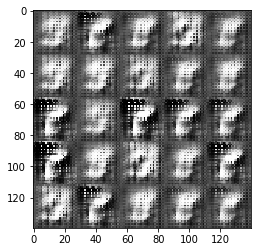

Step 610, Epoch 1/2... Discriminator Loss: 0.5033... Generator Loss: 2.5273
Step 620, Epoch 1/2... Discriminator Loss: 0.5608... Generator Loss: 2.2752
Step 630, Epoch 1/2... Discriminator Loss: 0.8479... Generator Loss: 1.3825
Step 640, Epoch 1/2... Discriminator Loss: 0.6860... Generator Loss: 2.2780
Step 650, Epoch 1/2... Discriminator Loss: 0.4770... Generator Loss: 2.6499
Step 660, Epoch 1/2... Discriminator Loss: 0.4236... Generator Loss: 3.5079
Step 670, Epoch 1/2... Discriminator Loss: 0.3621... Generator Loss: 6.3222
Step 680, Epoch 1/2... Discriminator Loss: 0.4303... Generator Loss: 2.6816
Step 690, Epoch 1/2... Discriminator Loss: 0.4436... Generator Loss: 3.8968
Step 700, Epoch 1/2... Discriminator Loss: 0.3918... Generator Loss: 3.6608


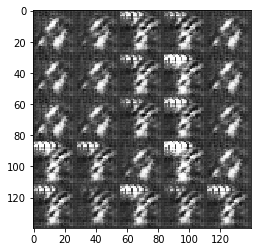

Step 710, Epoch 1/2... Discriminator Loss: 0.4289... Generator Loss: 2.7288
Step 720, Epoch 1/2... Discriminator Loss: 0.3650... Generator Loss: 6.4052
Step 730, Epoch 1/2... Discriminator Loss: 0.3726... Generator Loss: 3.4080
Step 740, Epoch 1/2... Discriminator Loss: 2.2587... Generator Loss: 3.9935
Step 750, Epoch 1/2... Discriminator Loss: 1.0115... Generator Loss: 2.2852
Step 760, Epoch 1/2... Discriminator Loss: 1.0905... Generator Loss: 0.9996
Step 770, Epoch 1/2... Discriminator Loss: 0.6731... Generator Loss: 1.6657
Step 780, Epoch 1/2... Discriminator Loss: 0.8484... Generator Loss: 1.6860
Step 790, Epoch 1/2... Discriminator Loss: 0.5898... Generator Loss: 2.0903
Step 800, Epoch 1/2... Discriminator Loss: 0.7650... Generator Loss: 1.8832


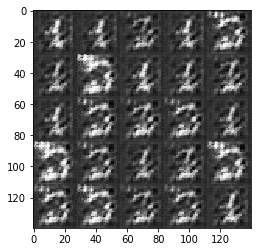

Step 810, Epoch 1/2... Discriminator Loss: 0.4584... Generator Loss: 2.7898
Step 820, Epoch 1/2... Discriminator Loss: 0.3795... Generator Loss: 4.4534
Step 830, Epoch 1/2... Discriminator Loss: 0.6221... Generator Loss: 2.3039
Step 840, Epoch 1/2... Discriminator Loss: 0.5245... Generator Loss: 2.2493
Step 850, Epoch 1/2... Discriminator Loss: 0.5024... Generator Loss: 2.1937
Step 860, Epoch 1/2... Discriminator Loss: 0.5228... Generator Loss: 2.0427
Step 870, Epoch 1/2... Discriminator Loss: 0.9028... Generator Loss: 1.9633
Step 880, Epoch 1/2... Discriminator Loss: 0.5241... Generator Loss: 2.1311
Step 890, Epoch 1/2... Discriminator Loss: 0.3629... Generator Loss: 4.8865
Step 900, Epoch 1/2... Discriminator Loss: 0.3567... Generator Loss: 5.4079


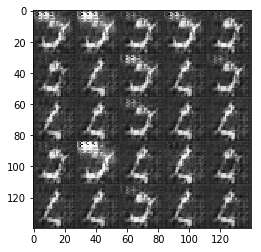

Step 910, Epoch 1/2... Discriminator Loss: 0.5771... Generator Loss: 2.4620
Step 920, Epoch 1/2... Discriminator Loss: 0.4404... Generator Loss: 3.8001
Step 930, Epoch 1/2... Discriminator Loss: 0.3738... Generator Loss: 4.5582
Step 940, Epoch 2/2... Discriminator Loss: 0.3818... Generator Loss: 3.5130
Step 950, Epoch 2/2... Discriminator Loss: 0.3864... Generator Loss: 4.3257
Step 960, Epoch 2/2... Discriminator Loss: 0.3545... Generator Loss: 5.1465
Step 970, Epoch 2/2... Discriminator Loss: 0.3834... Generator Loss: 3.3944
Step 980, Epoch 2/2... Discriminator Loss: 0.4977... Generator Loss: 10.5940
Step 990, Epoch 2/2... Discriminator Loss: 0.4106... Generator Loss: 5.6670
Step 1000, Epoch 2/2... Discriminator Loss: 0.4181... Generator Loss: 3.1631


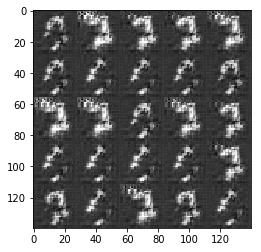

Step 1010, Epoch 2/2... Discriminator Loss: 0.3997... Generator Loss: 4.7445
Step 1020, Epoch 2/2... Discriminator Loss: 0.4400... Generator Loss: 2.8842
Step 1030, Epoch 2/2... Discriminator Loss: 0.3659... Generator Loss: 6.3187
Step 1040, Epoch 2/2... Discriminator Loss: 0.3527... Generator Loss: 4.7628
Step 1050, Epoch 2/2... Discriminator Loss: 0.3664... Generator Loss: 3.8923
Step 1060, Epoch 2/2... Discriminator Loss: 0.3887... Generator Loss: 3.8023
Step 1070, Epoch 2/2... Discriminator Loss: 0.4744... Generator Loss: 2.3123
Step 1080, Epoch 2/2... Discriminator Loss: 0.7973... Generator Loss: 1.7640
Step 1090, Epoch 2/2... Discriminator Loss: 0.5186... Generator Loss: 2.4438
Step 1100, Epoch 2/2... Discriminator Loss: 0.4775... Generator Loss: 2.6161


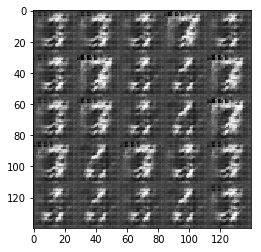

Step 1110, Epoch 2/2... Discriminator Loss: 0.4627... Generator Loss: 3.1321
Step 1120, Epoch 2/2... Discriminator Loss: 0.5917... Generator Loss: 3.8517
Step 1130, Epoch 2/2... Discriminator Loss: 0.7854... Generator Loss: 4.0345
Step 1140, Epoch 2/2... Discriminator Loss: 0.5736... Generator Loss: 2.7690
Step 1150, Epoch 2/2... Discriminator Loss: 0.6989... Generator Loss: 1.5188
Step 1160, Epoch 2/2... Discriminator Loss: 0.7897... Generator Loss: 4.2918
Step 1170, Epoch 2/2... Discriminator Loss: 0.8211... Generator Loss: 3.9206
Step 1180, Epoch 2/2... Discriminator Loss: 1.1389... Generator Loss: 5.1342
Step 1190, Epoch 2/2... Discriminator Loss: 0.4856... Generator Loss: 2.5726
Step 1200, Epoch 2/2... Discriminator Loss: 0.3757... Generator Loss: 5.7780


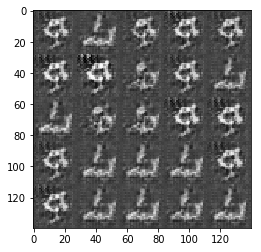

Step 1210, Epoch 2/2... Discriminator Loss: 0.3939... Generator Loss: 3.4500
Step 1220, Epoch 2/2... Discriminator Loss: 3.4513... Generator Loss: 0.1564
Step 1230, Epoch 2/2... Discriminator Loss: 0.7208... Generator Loss: 2.1865
Step 1240, Epoch 2/2... Discriminator Loss: 1.8399... Generator Loss: 0.5204
Step 1250, Epoch 2/2... Discriminator Loss: 0.5881... Generator Loss: 3.0754
Step 1260, Epoch 2/2... Discriminator Loss: 0.4272... Generator Loss: 4.1847
Step 1270, Epoch 2/2... Discriminator Loss: 0.4671... Generator Loss: 2.6360
Step 1280, Epoch 2/2... Discriminator Loss: 0.7200... Generator Loss: 4.6641
Step 1290, Epoch 2/2... Discriminator Loss: 0.6503... Generator Loss: 1.6509
Step 1300, Epoch 2/2... Discriminator Loss: 0.5766... Generator Loss: 3.0988


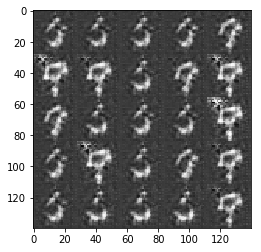

Step 1310, Epoch 2/2... Discriminator Loss: 0.4679... Generator Loss: 2.9236
Step 1320, Epoch 2/2... Discriminator Loss: 0.5248... Generator Loss: 2.1196
Step 1330, Epoch 2/2... Discriminator Loss: 0.3834... Generator Loss: 4.7902
Step 1340, Epoch 2/2... Discriminator Loss: 0.4950... Generator Loss: 3.6116
Step 1350, Epoch 2/2... Discriminator Loss: 0.4518... Generator Loss: 2.7592
Step 1360, Epoch 2/2... Discriminator Loss: 0.3750... Generator Loss: 4.7159
Step 1370, Epoch 2/2... Discriminator Loss: 0.3630... Generator Loss: 4.6217
Step 1380, Epoch 2/2... Discriminator Loss: 0.3497... Generator Loss: 6.0267
Step 1390, Epoch 2/2... Discriminator Loss: 0.5921... Generator Loss: 1.6730
Step 1400, Epoch 2/2... Discriminator Loss: 0.6099... Generator Loss: 4.7812


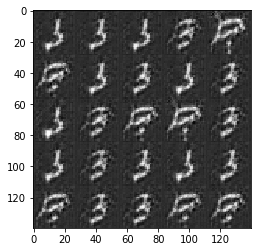

Step 1410, Epoch 2/2... Discriminator Loss: 0.4862... Generator Loss: 2.5409
Step 1420, Epoch 2/2... Discriminator Loss: 0.4351... Generator Loss: 4.6803
Step 1430, Epoch 2/2... Discriminator Loss: 0.6001... Generator Loss: 2.1448
Step 1440, Epoch 2/2... Discriminator Loss: 0.4297... Generator Loss: 3.9955
Step 1450, Epoch 2/2... Discriminator Loss: 0.4481... Generator Loss: 2.9418
Step 1460, Epoch 2/2... Discriminator Loss: 0.5142... Generator Loss: 2.3692
Step 1470, Epoch 2/2... Discriminator Loss: 0.4454... Generator Loss: 2.7909
Step 1480, Epoch 2/2... Discriminator Loss: 0.3834... Generator Loss: 7.7542
Step 1490, Epoch 2/2... Discriminator Loss: 0.4627... Generator Loss: 6.6531
Step 1500, Epoch 2/2... Discriminator Loss: 0.3890... Generator Loss: 3.7043


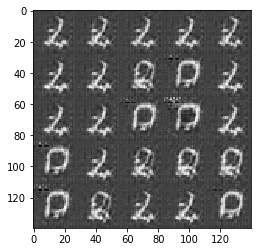

Step 1510, Epoch 2/2... Discriminator Loss: 0.9418... Generator Loss: 2.5100
Step 1520, Epoch 2/2... Discriminator Loss: 0.5217... Generator Loss: 2.4274
Step 1530, Epoch 2/2... Discriminator Loss: 0.5595... Generator Loss: 2.1628
Step 1540, Epoch 2/2... Discriminator Loss: 0.4327... Generator Loss: 3.0659
Step 1550, Epoch 2/2... Discriminator Loss: 0.4223... Generator Loss: 3.4623
Step 1560, Epoch 2/2... Discriminator Loss: 0.5407... Generator Loss: 2.1775
Step 1570, Epoch 2/2... Discriminator Loss: 0.4662... Generator Loss: 2.5404
Step 1580, Epoch 2/2... Discriminator Loss: 0.7091... Generator Loss: 1.8514
Step 1590, Epoch 2/2... Discriminator Loss: 0.4482... Generator Loss: 3.1028
Step 1600, Epoch 2/2... Discriminator Loss: 0.3769... Generator Loss: 4.6022


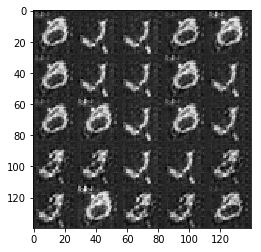

Step 1610, Epoch 2/2... Discriminator Loss: 0.4341... Generator Loss: 2.8955
Step 1620, Epoch 2/2... Discriminator Loss: 0.6971... Generator Loss: 6.8585
Step 1630, Epoch 2/2... Discriminator Loss: 0.5394... Generator Loss: 2.5481
Step 1640, Epoch 2/2... Discriminator Loss: 0.4644... Generator Loss: 2.8273
Step 1650, Epoch 2/2... Discriminator Loss: 0.4049... Generator Loss: 5.0852
Step 1660, Epoch 2/2... Discriminator Loss: 0.4355... Generator Loss: 2.7284
Step 1670, Epoch 2/2... Discriminator Loss: 0.7610... Generator Loss: 7.0092
Step 1680, Epoch 2/2... Discriminator Loss: 0.4170... Generator Loss: 3.2782
Step 1690, Epoch 2/2... Discriminator Loss: 0.7335... Generator Loss: 1.3746
Step 1700, Epoch 2/2... Discriminator Loss: 0.3786... Generator Loss: 4.0896


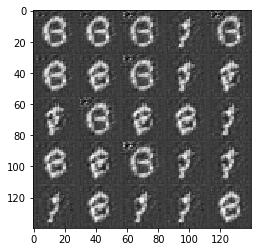

Step 1710, Epoch 2/2... Discriminator Loss: 0.4265... Generator Loss: 2.9790
Step 1720, Epoch 2/2... Discriminator Loss: 0.4208... Generator Loss: 3.0836
Step 1730, Epoch 2/2... Discriminator Loss: 0.6634... Generator Loss: 2.1620
Step 1740, Epoch 2/2... Discriminator Loss: 0.3715... Generator Loss: 5.0897
Step 1750, Epoch 2/2... Discriminator Loss: 0.3779... Generator Loss: 4.4979
Step 1760, Epoch 2/2... Discriminator Loss: 0.5199... Generator Loss: 2.7754
Step 1770, Epoch 2/2... Discriminator Loss: 0.4381... Generator Loss: 3.0745
Step 1780, Epoch 2/2... Discriminator Loss: 0.6878... Generator Loss: 4.3346
Step 1790, Epoch 2/2... Discriminator Loss: 0.4974... Generator Loss: 2.7670
Step 1800, Epoch 2/2... Discriminator Loss: 0.3914... Generator Loss: 4.1055


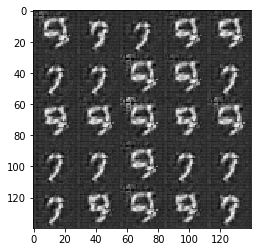

Step 1810, Epoch 2/2... Discriminator Loss: 0.4967... Generator Loss: 2.3562
Step 1820, Epoch 2/2... Discriminator Loss: 0.5151... Generator Loss: 2.1631
Step 1830, Epoch 2/2... Discriminator Loss: 0.4259... Generator Loss: 2.7521
Step 1840, Epoch 2/2... Discriminator Loss: 0.4448... Generator Loss: 3.4013
Step 1850, Epoch 2/2... Discriminator Loss: 0.4498... Generator Loss: 2.8753
Step 1860, Epoch 2/2... Discriminator Loss: 0.3720... Generator Loss: 5.3238
Step 1870, Epoch 2/2... Discriminator Loss: 0.3522... Generator Loss: 7.7051


In [18]:
batch_size = 32
z_dim = 200
learning_rate = 1e-3
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Step 10, Epoch 1/1... Discriminator Loss: 7.3332... Generator Loss: 0.0071
Step 20, Epoch 1/1... Discriminator Loss: 5.5160... Generator Loss: 0.0282
Step 30, Epoch 1/1... Discriminator Loss: 6.4842... Generator Loss: 0.0140
Step 40, Epoch 1/1... Discriminator Loss: 5.5899... Generator Loss: 0.0096
Step 50, Epoch 1/1... Discriminator Loss: 5.2403... Generator Loss: 0.0143
Step 60, Epoch 1/1... Discriminator Loss: 3.7845... Generator Loss: 0.0503
Step 70, Epoch 1/1... Discriminator Loss: 1.8335... Generator Loss: 0.5080
Step 80, Epoch 1/1... Discriminator Loss: 1.8336... Generator Loss: 0.5703
Step 90, Epoch 1/1... Discriminator Loss: 1.7326... Generator Loss: 0.8521
Step 100, Epoch 1/1... Discriminator Loss: 1.2599... Generator Loss: 1.1460


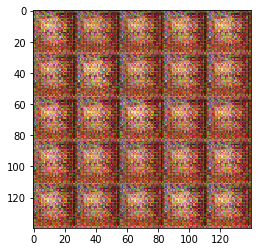

Step 110, Epoch 1/1... Discriminator Loss: 2.6330... Generator Loss: 0.5408
Step 120, Epoch 1/1... Discriminator Loss: 1.5327... Generator Loss: 1.0783
Step 130, Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 0.9265
Step 140, Epoch 1/1... Discriminator Loss: 1.5375... Generator Loss: 0.8235
Step 150, Epoch 1/1... Discriminator Loss: 1.8355... Generator Loss: 0.6566
Step 160, Epoch 1/1... Discriminator Loss: 1.1954... Generator Loss: 1.1491
Step 170, Epoch 1/1... Discriminator Loss: 1.5232... Generator Loss: 0.9933
Step 180, Epoch 1/1... Discriminator Loss: 1.0090... Generator Loss: 1.6214
Step 190, Epoch 1/1... Discriminator Loss: 1.0234... Generator Loss: 1.3694
Step 200, Epoch 1/1... Discriminator Loss: 0.6414... Generator Loss: 2.1903


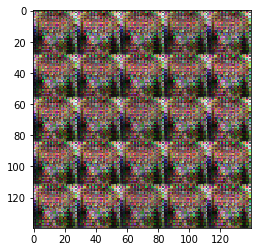

Step 210, Epoch 1/1... Discriminator Loss: 0.9204... Generator Loss: 1.2531
Step 220, Epoch 1/1... Discriminator Loss: 1.0040... Generator Loss: 1.2444
Step 230, Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.6236
Step 240, Epoch 1/1... Discriminator Loss: 1.0466... Generator Loss: 0.8301
Step 250, Epoch 1/1... Discriminator Loss: 0.8035... Generator Loss: 1.4520
Step 260, Epoch 1/1... Discriminator Loss: 0.9025... Generator Loss: 1.1654
Step 270, Epoch 1/1... Discriminator Loss: 0.6251... Generator Loss: 1.9761
Step 280, Epoch 1/1... Discriminator Loss: 0.6644... Generator Loss: 1.9007
Step 290, Epoch 1/1... Discriminator Loss: 0.6217... Generator Loss: 1.7878
Step 300, Epoch 1/1... Discriminator Loss: 0.7258... Generator Loss: 1.6450


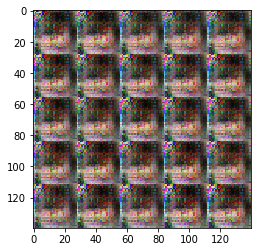

Step 310, Epoch 1/1... Discriminator Loss: 0.6539... Generator Loss: 1.9414
Step 320, Epoch 1/1... Discriminator Loss: 0.7041... Generator Loss: 1.4054
Step 330, Epoch 1/1... Discriminator Loss: 0.6367... Generator Loss: 2.0107
Step 340, Epoch 1/1... Discriminator Loss: 0.4588... Generator Loss: 3.2877
Step 350, Epoch 1/1... Discriminator Loss: 0.8407... Generator Loss: 2.9223
Step 360, Epoch 1/1... Discriminator Loss: 0.6220... Generator Loss: 1.6598
Step 370, Epoch 1/1... Discriminator Loss: 0.7795... Generator Loss: 1.8354
Step 380, Epoch 1/1... Discriminator Loss: 0.5480... Generator Loss: 2.7811
Step 390, Epoch 1/1... Discriminator Loss: 0.7373... Generator Loss: 1.5379
Step 400, Epoch 1/1... Discriminator Loss: 0.6909... Generator Loss: 2.9635


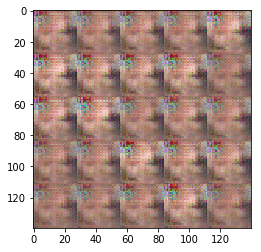

Step 410, Epoch 1/1... Discriminator Loss: 1.6574... Generator Loss: 0.6839
Step 420, Epoch 1/1... Discriminator Loss: 1.6428... Generator Loss: 1.0740
Step 430, Epoch 1/1... Discriminator Loss: 1.3322... Generator Loss: 0.6772
Step 440, Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.6781
Step 450, Epoch 1/1... Discriminator Loss: 1.5694... Generator Loss: 0.6605
Step 460, Epoch 1/1... Discriminator Loss: 1.5132... Generator Loss: 1.1345
Step 470, Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.9599
Step 480, Epoch 1/1... Discriminator Loss: 1.5716... Generator Loss: 0.7033
Step 490, Epoch 1/1... Discriminator Loss: 1.3228... Generator Loss: 0.7452
Step 500, Epoch 1/1... Discriminator Loss: 1.5045... Generator Loss: 0.6099


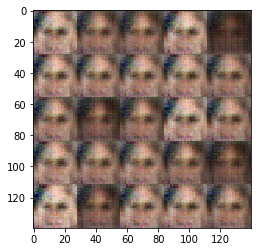

Step 510, Epoch 1/1... Discriminator Loss: 1.4726... Generator Loss: 0.8794
Step 520, Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.7620
Step 530, Epoch 1/1... Discriminator Loss: 1.6883... Generator Loss: 0.7427
Step 540, Epoch 1/1... Discriminator Loss: 1.4209... Generator Loss: 0.7404
Step 550, Epoch 1/1... Discriminator Loss: 1.6159... Generator Loss: 0.6595
Step 560, Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 0.7880
Step 570, Epoch 1/1... Discriminator Loss: 1.4549... Generator Loss: 1.1046
Step 580, Epoch 1/1... Discriminator Loss: 1.2452... Generator Loss: 0.8602
Step 590, Epoch 1/1... Discriminator Loss: 1.3561... Generator Loss: 0.8720
Step 600, Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 1.1676


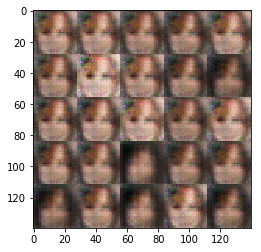

Step 610, Epoch 1/1... Discriminator Loss: 1.5915... Generator Loss: 0.9150
Step 620, Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.8062
Step 630, Epoch 1/1... Discriminator Loss: 1.1859... Generator Loss: 0.8981
Step 640, Epoch 1/1... Discriminator Loss: 1.5039... Generator Loss: 1.4690
Step 650, Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.7689
Step 660, Epoch 1/1... Discriminator Loss: 1.2323... Generator Loss: 0.9656
Step 670, Epoch 1/1... Discriminator Loss: 1.3103... Generator Loss: 0.8068
Step 680, Epoch 1/1... Discriminator Loss: 1.2193... Generator Loss: 1.0233
Step 690, Epoch 1/1... Discriminator Loss: 1.2280... Generator Loss: 0.9547
Step 700, Epoch 1/1... Discriminator Loss: 1.1881... Generator Loss: 0.9531


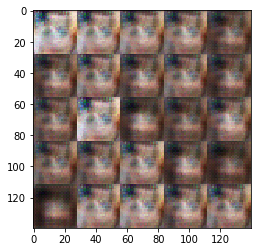

Step 710, Epoch 1/1... Discriminator Loss: 1.2587... Generator Loss: 0.9877
Step 720, Epoch 1/1... Discriminator Loss: 1.2400... Generator Loss: 0.8740
Step 730, Epoch 1/1... Discriminator Loss: 1.2850... Generator Loss: 0.8471
Step 740, Epoch 1/1... Discriminator Loss: 1.1167... Generator Loss: 1.3711
Step 750, Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 0.7312
Step 760, Epoch 1/1... Discriminator Loss: 1.1659... Generator Loss: 0.9965
Step 770, Epoch 1/1... Discriminator Loss: 1.0273... Generator Loss: 1.1026
Step 780, Epoch 1/1... Discriminator Loss: 1.0061... Generator Loss: 1.1121
Step 790, Epoch 1/1... Discriminator Loss: 1.2518... Generator Loss: 1.0514
Step 800, Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.8250


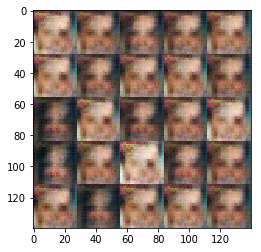

Step 810, Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.6753
Step 820, Epoch 1/1... Discriminator Loss: 1.5241... Generator Loss: 0.5981
Step 830, Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.7370
Step 840, Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 0.8501
Step 850, Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.7216
Step 860, Epoch 1/1... Discriminator Loss: 1.3139... Generator Loss: 0.8857
Step 870, Epoch 1/1... Discriminator Loss: 1.3319... Generator Loss: 0.7919
Step 880, Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 0.7810
Step 890, Epoch 1/1... Discriminator Loss: 1.3423... Generator Loss: 0.9596
Step 900, Epoch 1/1... Discriminator Loss: 1.2481... Generator Loss: 0.8264


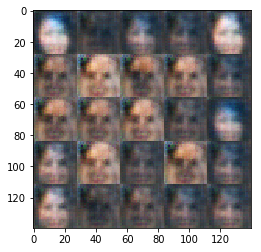

Step 910, Epoch 1/1... Discriminator Loss: 1.3468... Generator Loss: 0.9462
Step 920, Epoch 1/1... Discriminator Loss: 1.6160... Generator Loss: 0.4655
Step 930, Epoch 1/1... Discriminator Loss: 1.6308... Generator Loss: 0.4367
Step 940, Epoch 1/1... Discriminator Loss: 1.1902... Generator Loss: 0.8873
Step 950, Epoch 1/1... Discriminator Loss: 1.6731... Generator Loss: 0.3830
Step 960, Epoch 1/1... Discriminator Loss: 1.5094... Generator Loss: 0.4982
Step 970, Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 0.8929
Step 980, Epoch 1/1... Discriminator Loss: 1.2743... Generator Loss: 1.8259
Step 990, Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 0.5214
Step 1000, Epoch 1/1... Discriminator Loss: 1.1795... Generator Loss: 1.8281


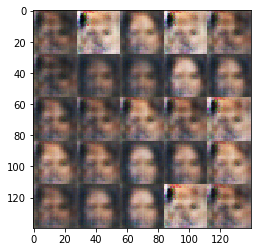

Step 1010, Epoch 1/1... Discriminator Loss: 1.0734... Generator Loss: 1.4170
Step 1020, Epoch 1/1... Discriminator Loss: 1.0617... Generator Loss: 1.0110
Step 1030, Epoch 1/1... Discriminator Loss: 1.4440... Generator Loss: 0.6019
Step 1040, Epoch 1/1... Discriminator Loss: 1.0330... Generator Loss: 1.6824
Step 1050, Epoch 1/1... Discriminator Loss: 0.9012... Generator Loss: 1.4662
Step 1060, Epoch 1/1... Discriminator Loss: 1.5757... Generator Loss: 2.2536
Step 1070, Epoch 1/1... Discriminator Loss: 1.2149... Generator Loss: 0.8012
Step 1080, Epoch 1/1... Discriminator Loss: 1.1303... Generator Loss: 0.9502
Step 1090, Epoch 1/1... Discriminator Loss: 1.9150... Generator Loss: 0.3360
Step 1100, Epoch 1/1... Discriminator Loss: 1.1701... Generator Loss: 0.7304


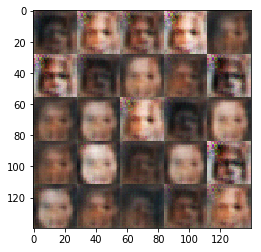

Step 1110, Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 1.7089
Step 1120, Epoch 1/1... Discriminator Loss: 1.5207... Generator Loss: 0.4859
Step 1130, Epoch 1/1... Discriminator Loss: 0.9389... Generator Loss: 1.6763
Step 1140, Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 1.2421
Step 1150, Epoch 1/1... Discriminator Loss: 1.2532... Generator Loss: 1.7049
Step 1160, Epoch 1/1... Discriminator Loss: 1.2549... Generator Loss: 1.3549
Step 1170, Epoch 1/1... Discriminator Loss: 1.0936... Generator Loss: 1.0080
Step 1180, Epoch 1/1... Discriminator Loss: 1.3409... Generator Loss: 1.2159
Step 1190, Epoch 1/1... Discriminator Loss: 1.1586... Generator Loss: 1.5619
Step 1200, Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 1.2751


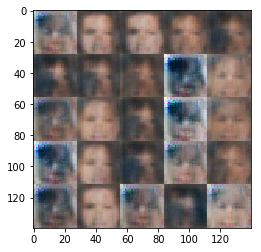

Step 1210, Epoch 1/1... Discriminator Loss: 1.1524... Generator Loss: 0.8751
Step 1220, Epoch 1/1... Discriminator Loss: 1.2009... Generator Loss: 1.1535
Step 1230, Epoch 1/1... Discriminator Loss: 1.1149... Generator Loss: 1.0288
Step 1240, Epoch 1/1... Discriminator Loss: 1.5959... Generator Loss: 0.4298
Step 1250, Epoch 1/1... Discriminator Loss: 1.4995... Generator Loss: 0.5150
Step 1260, Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.7538
Step 1270, Epoch 1/1... Discriminator Loss: 1.2261... Generator Loss: 1.1887
Step 1280, Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.9770
Step 1290, Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.7955
Step 1300, Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 0.6313


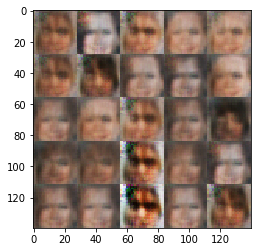

Step 1310, Epoch 1/1... Discriminator Loss: 1.4874... Generator Loss: 0.4910
Step 1320, Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.5842
Step 1330, Epoch 1/1... Discriminator Loss: 1.2805... Generator Loss: 0.7798
Step 1340, Epoch 1/1... Discriminator Loss: 1.5095... Generator Loss: 0.5313
Step 1350, Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.5844
Step 1360, Epoch 1/1... Discriminator Loss: 1.7173... Generator Loss: 0.3474
Step 1370, Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 1.1415
Step 1380, Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.5871
Step 1390, Epoch 1/1... Discriminator Loss: 1.0741... Generator Loss: 1.6312
Step 1400, Epoch 1/1... Discriminator Loss: 1.2455... Generator Loss: 0.7749


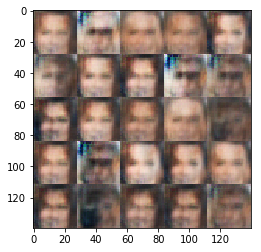

Step 1410, Epoch 1/1... Discriminator Loss: 1.4501... Generator Loss: 0.5385
Step 1420, Epoch 1/1... Discriminator Loss: 1.2879... Generator Loss: 1.0119
Step 1430, Epoch 1/1... Discriminator Loss: 1.2182... Generator Loss: 1.4815
Step 1440, Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 1.0040
Step 1450, Epoch 1/1... Discriminator Loss: 1.2766... Generator Loss: 0.8573
Step 1460, Epoch 1/1... Discriminator Loss: 1.2027... Generator Loss: 1.4653
Step 1470, Epoch 1/1... Discriminator Loss: 1.2820... Generator Loss: 0.9522
Step 1480, Epoch 1/1... Discriminator Loss: 1.2224... Generator Loss: 1.7729
Step 1490, Epoch 1/1... Discriminator Loss: 1.2746... Generator Loss: 0.7181
Step 1500, Epoch 1/1... Discriminator Loss: 1.2756... Generator Loss: 0.7838


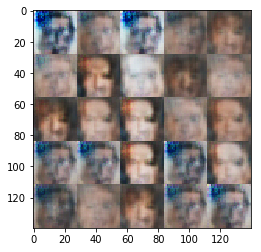

Step 1510, Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.6122
Step 1520, Epoch 1/1... Discriminator Loss: 1.2062... Generator Loss: 1.0960
Step 1530, Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.9872
Step 1540, Epoch 1/1... Discriminator Loss: 1.3058... Generator Loss: 0.6948
Step 1550, Epoch 1/1... Discriminator Loss: 1.2703... Generator Loss: 0.6695
Step 1560, Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.8842
Step 1570, Epoch 1/1... Discriminator Loss: 1.0810... Generator Loss: 1.1585
Step 1580, Epoch 1/1... Discriminator Loss: 1.1691... Generator Loss: 1.0866
Step 1590, Epoch 1/1... Discriminator Loss: 1.2842... Generator Loss: 1.2852
Step 1600, Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 1.8357


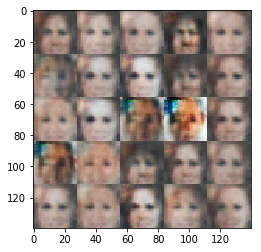

Step 1610, Epoch 1/1... Discriminator Loss: 1.1699... Generator Loss: 1.2823
Step 1620, Epoch 1/1... Discriminator Loss: 1.5557... Generator Loss: 1.5280
Step 1630, Epoch 1/1... Discriminator Loss: 1.2378... Generator Loss: 0.8070
Step 1640, Epoch 1/1... Discriminator Loss: 1.1864... Generator Loss: 1.0011
Step 1650, Epoch 1/1... Discriminator Loss: 2.0228... Generator Loss: 0.2360
Step 1660, Epoch 1/1... Discriminator Loss: 1.5188... Generator Loss: 1.4640
Step 1670, Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.6665
Step 1680, Epoch 1/1... Discriminator Loss: 1.2764... Generator Loss: 0.8926
Step 1690, Epoch 1/1... Discriminator Loss: 1.2713... Generator Loss: 0.6324
Step 1700, Epoch 1/1... Discriminator Loss: 1.3261... Generator Loss: 0.5817


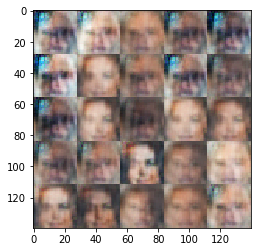

Step 1710, Epoch 1/1... Discriminator Loss: 1.0866... Generator Loss: 1.8321
Step 1720, Epoch 1/1... Discriminator Loss: 1.1932... Generator Loss: 1.1535
Step 1730, Epoch 1/1... Discriminator Loss: 0.9520... Generator Loss: 1.4720
Step 1740, Epoch 1/1... Discriminator Loss: 1.1458... Generator Loss: 1.0215
Step 1750, Epoch 1/1... Discriminator Loss: 1.8347... Generator Loss: 0.2917
Step 1760, Epoch 1/1... Discriminator Loss: 1.5395... Generator Loss: 0.4260
Step 1770, Epoch 1/1... Discriminator Loss: 1.0336... Generator Loss: 1.0704
Step 1780, Epoch 1/1... Discriminator Loss: 1.1545... Generator Loss: 0.8826
Step 1790, Epoch 1/1... Discriminator Loss: 1.3066... Generator Loss: 0.6767
Step 1800, Epoch 1/1... Discriminator Loss: 1.6104... Generator Loss: 0.4042


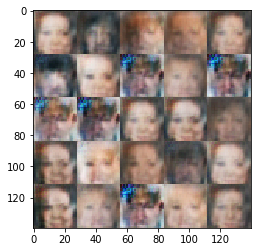

Step 1810, Epoch 1/1... Discriminator Loss: 0.9613... Generator Loss: 1.1723
Step 1820, Epoch 1/1... Discriminator Loss: 1.1176... Generator Loss: 0.8839
Step 1830, Epoch 1/1... Discriminator Loss: 1.2057... Generator Loss: 0.9495
Step 1840, Epoch 1/1... Discriminator Loss: 1.1571... Generator Loss: 1.1509
Step 1850, Epoch 1/1... Discriminator Loss: 1.2732... Generator Loss: 0.8763
Step 1860, Epoch 1/1... Discriminator Loss: 1.1093... Generator Loss: 1.0793
Step 1870, Epoch 1/1... Discriminator Loss: 1.1802... Generator Loss: 1.6105
Step 1880, Epoch 1/1... Discriminator Loss: 1.2138... Generator Loss: 1.4948
Step 1890, Epoch 1/1... Discriminator Loss: 1.0726... Generator Loss: 2.0319
Step 1900, Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.6412


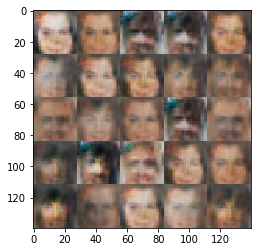

Step 1910, Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.6222
Step 1920, Epoch 1/1... Discriminator Loss: 1.0581... Generator Loss: 1.2498
Step 1930, Epoch 1/1... Discriminator Loss: 1.3448... Generator Loss: 0.8092
Step 1940, Epoch 1/1... Discriminator Loss: 1.2945... Generator Loss: 0.6952
Step 1950, Epoch 1/1... Discriminator Loss: 1.5363... Generator Loss: 0.4357
Step 1960, Epoch 1/1... Discriminator Loss: 1.5896... Generator Loss: 0.4012
Step 1970, Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.6133
Step 1980, Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.5537
Step 1990, Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.6586
Step 2000, Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.6923


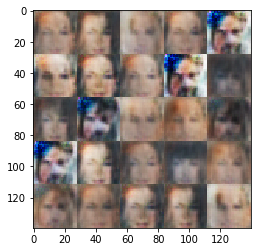

Step 2010, Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.6685
Step 2020, Epoch 1/1... Discriminator Loss: 1.0818... Generator Loss: 0.8718
Step 2030, Epoch 1/1... Discriminator Loss: 1.6750... Generator Loss: 0.3748
Step 2040, Epoch 1/1... Discriminator Loss: 1.0908... Generator Loss: 1.1621
Step 2050, Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 2.0817
Step 2060, Epoch 1/1... Discriminator Loss: 1.1721... Generator Loss: 0.9806
Step 2070, Epoch 1/1... Discriminator Loss: 1.2042... Generator Loss: 1.0344
Step 2080, Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 0.8868
Step 2090, Epoch 1/1... Discriminator Loss: 1.6637... Generator Loss: 0.3805
Step 2100, Epoch 1/1... Discriminator Loss: 1.1529... Generator Loss: 0.9874


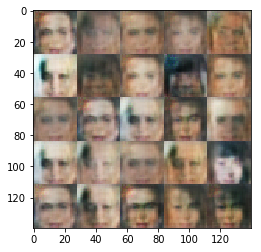

Step 2110, Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 1.6778
Step 2120, Epoch 1/1... Discriminator Loss: 1.0682... Generator Loss: 1.0213
Step 2130, Epoch 1/1... Discriminator Loss: 1.1487... Generator Loss: 2.2603
Step 2140, Epoch 1/1... Discriminator Loss: 1.3111... Generator Loss: 0.7044
Step 2150, Epoch 1/1... Discriminator Loss: 1.2509... Generator Loss: 0.7162
Step 2160, Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.6482
Step 2170, Epoch 1/1... Discriminator Loss: 1.3157... Generator Loss: 0.6572
Step 2180, Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.5731
Step 2190, Epoch 1/1... Discriminator Loss: 1.6509... Generator Loss: 0.3624
Step 2200, Epoch 1/1... Discriminator Loss: 1.1264... Generator Loss: 1.1296


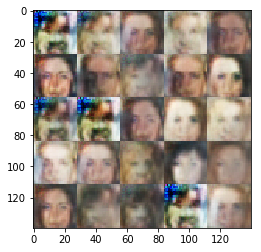

Step 2210, Epoch 1/1... Discriminator Loss: 1.1290... Generator Loss: 1.2633
Step 2220, Epoch 1/1... Discriminator Loss: 1.1779... Generator Loss: 2.3526
Step 2230, Epoch 1/1... Discriminator Loss: 1.0166... Generator Loss: 0.9503
Step 2240, Epoch 1/1... Discriminator Loss: 1.2025... Generator Loss: 0.6628
Step 2250, Epoch 1/1... Discriminator Loss: 1.1386... Generator Loss: 0.9036
Step 2260, Epoch 1/1... Discriminator Loss: 1.2190... Generator Loss: 0.8851
Step 2270, Epoch 1/1... Discriminator Loss: 1.1492... Generator Loss: 0.9401
Step 2280, Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 0.5914
Step 2290, Epoch 1/1... Discriminator Loss: 1.0519... Generator Loss: 1.5369
Step 2300, Epoch 1/1... Discriminator Loss: 1.8771... Generator Loss: 0.2949


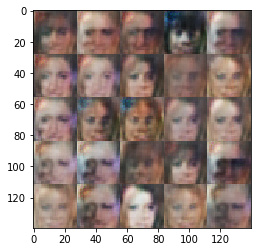

Step 2310, Epoch 1/1... Discriminator Loss: 1.5301... Generator Loss: 0.6326
Step 2320, Epoch 1/1... Discriminator Loss: 1.0651... Generator Loss: 1.3306
Step 2330, Epoch 1/1... Discriminator Loss: 1.0744... Generator Loss: 1.0935
Step 2340, Epoch 1/1... Discriminator Loss: 1.2108... Generator Loss: 0.6631
Step 2350, Epoch 1/1... Discriminator Loss: 1.4657... Generator Loss: 0.4460
Step 2360, Epoch 1/1... Discriminator Loss: 1.2337... Generator Loss: 0.7121
Step 2370, Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 0.6481
Step 2380, Epoch 1/1... Discriminator Loss: 1.3228... Generator Loss: 2.1079
Step 2390, Epoch 1/1... Discriminator Loss: 0.9086... Generator Loss: 1.5619
Step 2400, Epoch 1/1... Discriminator Loss: 0.7395... Generator Loss: 1.5750


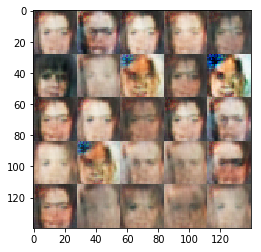

Step 2410, Epoch 1/1... Discriminator Loss: 0.8142... Generator Loss: 1.7112
Step 2420, Epoch 1/1... Discriminator Loss: 1.1675... Generator Loss: 0.7194
Step 2430, Epoch 1/1... Discriminator Loss: 1.1550... Generator Loss: 0.7876
Step 2440, Epoch 1/1... Discriminator Loss: 0.5429... Generator Loss: 3.2167
Step 2450, Epoch 1/1... Discriminator Loss: 0.8473... Generator Loss: 2.1267
Step 2460, Epoch 1/1... Discriminator Loss: 0.8032... Generator Loss: 2.4522
Step 2470, Epoch 1/1... Discriminator Loss: 0.7191... Generator Loss: 2.8766
Step 2480, Epoch 1/1... Discriminator Loss: 0.7195... Generator Loss: 1.8865
Step 2490, Epoch 1/1... Discriminator Loss: 1.6594... Generator Loss: 0.4003
Step 2500, Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 1.0697


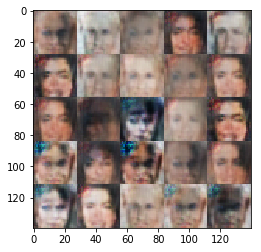

Step 2510, Epoch 1/1... Discriminator Loss: 0.8822... Generator Loss: 1.4252
Step 2520, Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.5656
Step 2530, Epoch 1/1... Discriminator Loss: 1.0712... Generator Loss: 0.9673
Step 2540, Epoch 1/1... Discriminator Loss: 0.8756... Generator Loss: 1.1696
Step 2550, Epoch 1/1... Discriminator Loss: 1.7444... Generator Loss: 1.9121
Step 2560, Epoch 1/1... Discriminator Loss: 1.1087... Generator Loss: 0.8637
Step 2570, Epoch 1/1... Discriminator Loss: 1.0096... Generator Loss: 1.2400
Step 2580, Epoch 1/1... Discriminator Loss: 1.0394... Generator Loss: 3.0276
Step 2590, Epoch 1/1... Discriminator Loss: 0.5215... Generator Loss: 2.8229
Step 2600, Epoch 1/1... Discriminator Loss: 1.0615... Generator Loss: 1.4246


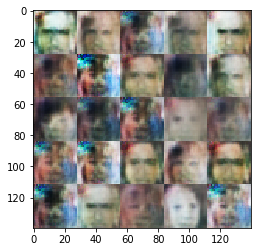

Step 2610, Epoch 1/1... Discriminator Loss: 0.6589... Generator Loss: 3.4365
Step 2620, Epoch 1/1... Discriminator Loss: 1.0506... Generator Loss: 3.6213
Step 2630, Epoch 1/1... Discriminator Loss: 0.5841... Generator Loss: 2.4992
Step 2640, Epoch 1/1... Discriminator Loss: 0.6772... Generator Loss: 1.9368
Step 2650, Epoch 1/1... Discriminator Loss: 1.5619... Generator Loss: 0.4347
Step 2660, Epoch 1/1... Discriminator Loss: 1.5145... Generator Loss: 0.7990
Step 2670, Epoch 1/1... Discriminator Loss: 1.1191... Generator Loss: 1.3754
Step 2680, Epoch 1/1... Discriminator Loss: 1.0938... Generator Loss: 1.5776
Step 2690, Epoch 1/1... Discriminator Loss: 1.1670... Generator Loss: 0.6834
Step 2700, Epoch 1/1... Discriminator Loss: 0.9098... Generator Loss: 1.0287


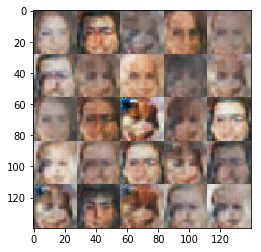

Step 2710, Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.4796
Step 2720, Epoch 1/1... Discriminator Loss: 1.7940... Generator Loss: 1.3266
Step 2730, Epoch 1/1... Discriminator Loss: 1.1290... Generator Loss: 1.1494
Step 2740, Epoch 1/1... Discriminator Loss: 0.7563... Generator Loss: 1.3096
Step 2750, Epoch 1/1... Discriminator Loss: 0.9179... Generator Loss: 1.2934
Step 2760, Epoch 1/1... Discriminator Loss: 1.3031... Generator Loss: 0.5735
Step 2770, Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.4798
Step 2780, Epoch 1/1... Discriminator Loss: 1.6641... Generator Loss: 0.5152
Step 2790, Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 0.8508
Step 2800, Epoch 1/1... Discriminator Loss: 0.6358... Generator Loss: 3.8008


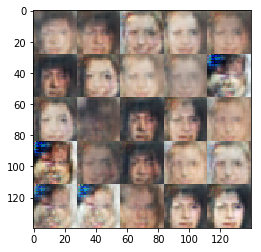

Step 2810, Epoch 1/1... Discriminator Loss: 0.7238... Generator Loss: 2.3471
Step 2820, Epoch 1/1... Discriminator Loss: 0.8132... Generator Loss: 1.6920
Step 2830, Epoch 1/1... Discriminator Loss: 1.2817... Generator Loss: 0.5612
Step 2840, Epoch 1/1... Discriminator Loss: 1.1817... Generator Loss: 0.6483
Step 2850, Epoch 1/1... Discriminator Loss: 1.6666... Generator Loss: 0.7806
Step 2860, Epoch 1/1... Discriminator Loss: 0.9781... Generator Loss: 1.1140
Step 2870, Epoch 1/1... Discriminator Loss: 0.8099... Generator Loss: 2.6268
Step 2880, Epoch 1/1... Discriminator Loss: 0.9656... Generator Loss: 0.8472
Step 2890, Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 1.5261
Step 2900, Epoch 1/1... Discriminator Loss: 0.8215... Generator Loss: 1.4809


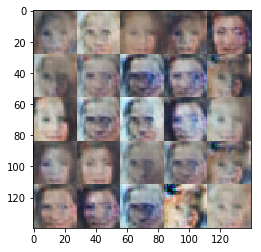

Step 2910, Epoch 1/1... Discriminator Loss: 0.5959... Generator Loss: 1.8463
Step 2920, Epoch 1/1... Discriminator Loss: 0.7267... Generator Loss: 1.4538
Step 2930, Epoch 1/1... Discriminator Loss: 0.7183... Generator Loss: 1.5542
Step 2940, Epoch 1/1... Discriminator Loss: 0.6807... Generator Loss: 1.9885
Step 2950, Epoch 1/1... Discriminator Loss: 0.8800... Generator Loss: 3.4468
Step 2960, Epoch 1/1... Discriminator Loss: 0.5646... Generator Loss: 2.4089
Step 2970, Epoch 1/1... Discriminator Loss: 0.7232... Generator Loss: 2.2257
Step 2980, Epoch 1/1... Discriminator Loss: 0.7922... Generator Loss: 1.3997
Step 2990, Epoch 1/1... Discriminator Loss: 0.4793... Generator Loss: 2.9023
Step 3000, Epoch 1/1... Discriminator Loss: 0.5277... Generator Loss: 2.0381


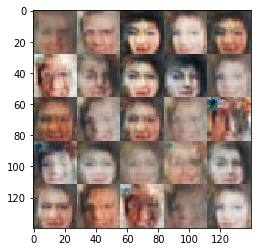

Step 3010, Epoch 1/1... Discriminator Loss: 1.2263... Generator Loss: 0.6286
Step 3020, Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.5183
Step 3030, Epoch 1/1... Discriminator Loss: 0.5626... Generator Loss: 1.9967
Step 3040, Epoch 1/1... Discriminator Loss: 1.0832... Generator Loss: 0.7294
Step 3050, Epoch 1/1... Discriminator Loss: 0.4622... Generator Loss: 2.7761
Step 3060, Epoch 1/1... Discriminator Loss: 0.8808... Generator Loss: 0.9852
Step 3070, Epoch 1/1... Discriminator Loss: 1.2726... Generator Loss: 0.5571
Step 3080, Epoch 1/1... Discriminator Loss: 1.7014... Generator Loss: 0.3320
Step 3090, Epoch 1/1... Discriminator Loss: 0.9312... Generator Loss: 0.9786
Step 3100, Epoch 1/1... Discriminator Loss: 0.5704... Generator Loss: 2.6435


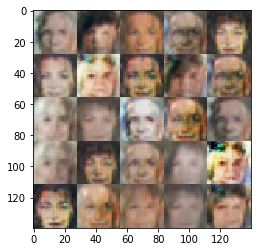

Step 3110, Epoch 1/1... Discriminator Loss: 0.7774... Generator Loss: 4.7437
Step 3120, Epoch 1/1... Discriminator Loss: 0.4384... Generator Loss: 3.1397
Step 3130, Epoch 1/1... Discriminator Loss: 0.5087... Generator Loss: 2.7539
Step 3140, Epoch 1/1... Discriminator Loss: 0.5254... Generator Loss: 2.5997
Step 3150, Epoch 1/1... Discriminator Loss: 1.1490... Generator Loss: 4.0608
Step 3160, Epoch 1/1... Discriminator Loss: 0.8926... Generator Loss: 2.6591


In [19]:
batch_size = 32
z_dim = 100
learning_rate = 2e-4
beta1 = 0.2
alpha =0.08

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, alpha=alpha)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.